In [1]:
import os, sys
cur_dir = os.getcwd()
basename = os.path.basename(cur_dir)
for _ in range(5):
    if basename != 'OCLog':
        cur_dir = os.path.dirname(cur_dir)
        basename = os.path.basename(cur_dir)
        #print(cur_dir, basename)
    else:
        if cur_dir not in sys.path:
            sys.path.append(cur_dir)
            #print(sys.path)
import os
from openpyxl import Workbook
from openpyxl import load_workbook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm import trange, tqdm, tnrange
from oclog.BGL.bglogUKC import BGLog, get_embedding_layer
from oclog.openset.boundary_loss import euclidean_metric, BoundaryLoss
from oclog.openset.pretraining import LogLineEncoder, LogSeqEncoder, LogClassifier
# from oclog.openset.openset import OpenSet
from oclog.openset.opensetv6 import OpenSet
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import sklearn.metrics as m
import warnings
warnings.filterwarnings('ignore')
def update_tracker(file_name, data):
    if os.path.exists(file_name):
        wb = load_workbook(file_name)
    else:
        wb = Workbook()    
    wb.save(file_name)
    # wb.close(file_name)
    orig_df = pd.read_excel(file_name,)
    #print(orig_df.head())
    new_df = pd.DataFrame(data, )
    concat_df = pd.concat([orig_df, new_df], axis=0)
    #print(concat_df.head())
    concat_df.to_excel(file_name)
    return concat_df

def oset_train(ablation=5000,designated_ukc_cls=3,num_classes=2,embedding_size=128,lr_rate=3,optimizer='sgd',
pretrain_epochs=3,octrain_epochs=50,wait_patient=3, debug=False, tracker='tracker.xlsx', comment=''):
    tf.random.set_seed(1234)
    np.random.seed(1234) 
    bglog = BGLog(save_padded_num_sequences=False, debug=debug,  load_from_pkl=True, )
    train_test = bglog.get_tensor_train_val_test(ablation=ablation, designated_ukc_cls=designated_ukc_cls )
    train_data, val_data, test_data = train_test
    line_encoder = LogLineEncoder(bglog, chars_in_line=64)
    logSeqencer =  LogSeqEncoder(line_in_seq=32, dense_neurons=embedding_size)
    ptmodel = LogClassifier(line_encoder=line_encoder, seq_encoder=logSeqencer, num_classes=num_classes)
    ptmodel.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    hist = ptmodel.fit(train_data, validation_data=val_data, epochs=pretrain_epochs)    
    oset = OpenSet(num_classes, ptmodel, embedding_size=embedding_size)
    _, _ = oset.train(train_data,data_val=val_data, epochs=octrain_epochs, lr_rate=lr_rate, wait_patient=wait_patient, optimizer=optimizer)
    _, _, f1_weighted, f_measure = oset.evaluate(test_data, ukc_label=designated_ukc_cls)
    lst = list(tf.reshape(oset.radius, (1, num_classes)).numpy()[0])
    lst = [str(i) for i in lst]
    radius = ','.join(lst)
    loss = oset.losses[len(oset.losses)-1].numpy()
    tracker_data = {'ablation':[ablation],'designated_ukc_cls': [designated_ukc_cls],'num_classes': [num_classes],
                   'embedding_size': [embedding_size], 'lr_rate': [lr_rate], 'optimizer': [optimizer],
                    'pretrain_epochs': [pretrain_epochs],'octrain_epochs': [octrain_epochs], 'wait_patient': [wait_patient], 
                   'f1_weighted': [f1_weighted], 'f1_macro': f_measure.get('F1-score'), 
                   'F1Known': f_measure.get('Known'), 'F1Open': f_measure.get('Open'), 'loss':[loss], 'Radius': radius,
                   'comment': comment}
    update_tracker(tracker, tracker_data)
    return test_data, oset

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 400
val_0:, 50
test_0:, 50
train_1:, 400
val_1:, 50
test_1:, 50
train_2:, 400
val_2:, 50
test_2:, 50
train_3:, 400
val_3:, 50
test_3:, 50
train_4:, 400
val_4:, 50
test_4:, 50
class 6 is added as ukc
ukc_6:, 50
vocab_size: 50
Epoch 1/14
62/62 [==============================] - 8s 99ms/step - loss: 1.1837 - accuracy: 0.5585 - precision_2: 0.9676 - recall_2: 0.2858 - val_loss: 1.0390 - val_accuracy: 0.6250 - val_precision_2: 1.0000 - val_recall_2: 0.3839
Epoch 2/14
62/62 [==============================] - 6s 99ms/step - loss: 0.6789 - accuracy: 0.7505 - precision_2: 0.9445 - recall_2: 0.6008 - val_loss: 0.5300 - val_accuracy: 0.8527 - val_precision_2: 0.9563 - val_recall_2: 0.7812
Epoch 3/14
62/62 [==============================] - 6s 96ms/step - loss: 0.4606 - accuracy: 0.8735 - precision_2: 0.942

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.43it/s]


epoch: 1/50, train_loss: 15.401331901550293, F1_train: 0.5670769657912151 F1_val: 0.38378803237635833


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.10it/s]


epoch: 2/50, train_loss: 15.378965377807617, F1_train: 0.6811872947056258 F1_val: 0.513938053291492


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.17it/s]


epoch: 3/50, train_loss: 15.374783515930176, F1_train: 0.7155560865938567 F1_val: 0.5951806440015098


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.32it/s]


epoch: 4/50, train_loss: 15.373117446899414, F1_train: 0.7421545116184292 F1_val: 0.6617546419629753


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.34it/s]


epoch: 5/50, train_loss: 15.411981582641602, F1_train: 0.7687872107020708 F1_val: 0.7104710095693496


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.80it/s]


epoch: 6/50, train_loss: 15.366006851196289, F1_train: 0.7880662474031781 F1_val: 0.7379668617728712


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.37it/s]


epoch: 7/50, train_loss: 15.368725776672363, F1_train: 0.8076298927192748 F1_val: 0.7730650192769416


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.40it/s]


epoch: 8/50, train_loss: 15.362293243408203, F1_train: 0.8283090824518694 F1_val: 0.8110114832010655


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.45it/s]


epoch: 9/50, train_loss: 15.384124755859375, F1_train: 0.8445650505365812 F1_val: 0.8587975911457028


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.46it/s]


epoch: 10/50, train_loss: 15.370051383972168, F1_train: 0.8629159195453958 F1_val: 0.8731684788394152


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.49it/s]


epoch: 11/50, train_loss: 15.4132719039917, F1_train: 0.8791265073889696 F1_val: 0.9199757151569468


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.46it/s]


epoch: 12/50, train_loss: 15.261612892150879, F1_train: 0.8969073332899724 F1_val: 0.9236912886587036


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.46it/s]


epoch: 13/50, train_loss: 15.36155891418457, F1_train: 0.9079187552592771 F1_val: 0.9429304821483845


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.45it/s]


epoch: 14/50, train_loss: 15.333009719848633, F1_train: 0.9148541437025186 F1_val: 0.9429495355834642


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.45it/s]


epoch: 15/50, train_loss: 15.40660285949707, F1_train: 0.9204661142459724 F1_val: 0.9428981382500489


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.45it/s]


epoch: 16/50, train_loss: 15.347530364990234, F1_train: 0.9250063607700418 F1_val: 0.9513153974190366


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.45it/s]


epoch: 17/50, train_loss: 15.367637634277344, F1_train: 0.9287923173950601 F1_val: 0.9563741418877482


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.43it/s]


epoch: 18/50, train_loss: 15.36622428894043, F1_train: 0.9304016633550141 F1_val: 0.9562425777903452


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.49it/s]


epoch: 19/50, train_loss: 15.418876647949219, F1_train: 0.9310095655915205 F1_val: 0.9535792981341119


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.48it/s]


epoch: 20/50, train_loss: 15.400623321533203, F1_train: 0.9316469016804814 F1_val: 0.9592224058185196


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.50it/s]


epoch: 21/50, train_loss: 15.365967750549316, F1_train: 0.9315909930999736 F1_val: 0.9540613888587688


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.47it/s]


epoch: 22/50, train_loss: 15.392633438110352, F1_train: 0.9337984441225499 F1_val: 0.9566053026259962


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.51it/s]


epoch: 23/50, train_loss: 15.398951530456543, F1_train: 0.9340771565388029 F1_val: 0.9565372350154012


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.50it/s]


epoch: 24/50, train_loss: 15.418896675109863, F1_train: 0.9338253341943885 F1_val: 0.956585056647857


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.40it/s]


epoch: 25/50, train_loss: 15.373104095458984, F1_train: 0.9340307852369159 F1_val: 0.9566331475679528


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.33it/s]


epoch: 26/50, train_loss: 15.444339752197266, F1_train: 0.9346838043414831 F1_val: 0.9568402556764021


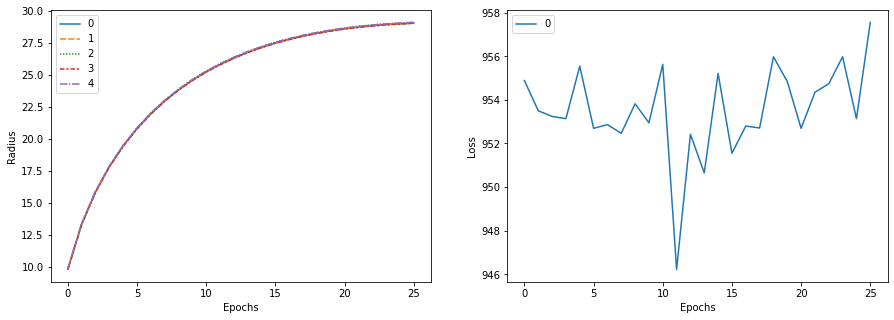

[[46  0  0  0  0  1]
 [ 0 49  0  0  0  0]
 [ 0  0 42  0  0  4]
 [ 0  0  0 33  0 13]
 [ 0  0  0  0 46  4]
 [ 0  2  0  0  0 48]]
91.67
f1_weighted: 0.9193429200642603, f1_macro: 0.919594856280238, f1_micro: 0.9166666666666666, f_measure: {'Known': 94.3514, 'Open': 80.0, 'F1-score': 91.9595}
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        47
           1       0.96      1.00      0.98        49
           2       1.00      0.91      0.95        46
           3       1.00      0.72      0.84        46
           4       1.00      0.92      0.96        50
           6       0.69      0.96      0.80        50

    accuracy                           0.92       288
   macro avg       0.94      0.91      0.92       288
weighted avg       0.94      0.92      0.92       288



In [4]:
comment="changing the ukc class t0 6 with best setting of ablation 500"
test_data, oset = oset_train(ablation=500,designated_ukc_cls=6,num_classes=5,embedding_size=2,
                             lr_rate=2, optimizer='nadam',
pretrain_epochs=14,octrain_epochs=50, wait_patient=6, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 480
val_0:, 60
test_0:, 60
train_1:, 480
val_1:, 60
test_1:, 60
train_2:, 480
val_2:, 60
test_2:, 60
train_3:, 480
val_3:, 60
test_3:, 60
train_4:, 480
val_4:, 60
test_4:, 60
class 5 is added as ukc
ukc_5:, 60
vocab_size: 50
Epoch 1/14
75/75 [==============================] - 8s 95ms/step - loss: 1.3688 - accuracy: 0.3242 - precision_3: 0.8308 - recall_3: 0.1617 - val_loss: 1.0349 - val_accuracy: 0.4896 - val_precision_3: 0.9580 - val_recall_3: 0.3958
Epoch 2/14
75/75 [==============================] - 7s 92ms/step - loss: 0.8597 - accuracy: 0.6358 - precision_3: 0.8976 - recall_3: 0.4600 - val_loss: 0.6832 - val_accuracy: 0.7639 - val_precision_3: 0.9402 - val_recall_3: 0.6007
Epoch 3/14
75/75 [==============================] - 7s 96ms/step - loss: 0.7474 - accuracy: 0.7179 - precision_3: 0.965

100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:10<00:00,  7.15it/s]


epoch: 1/50, train_loss: 6.592120170593262, F1_train: 0.8520650818882625 F1_val: 0.8203063703084401


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:10<00:00,  7.17it/s]


epoch: 2/50, train_loss: 6.592284202575684, F1_train: 0.9242237873530278 F1_val: 0.897928461685145


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:10<00:00,  7.14it/s]


epoch: 3/50, train_loss: 6.592180252075195, F1_train: 0.9515658962288799 F1_val: 0.9266843670955224


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:10<00:00,  7.14it/s]


epoch: 4/50, train_loss: 6.591987133026123, F1_train: 0.9578715740490632 F1_val: 0.9451933327952058


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:10<00:00,  7.13it/s]


epoch: 5/50, train_loss: 6.5920281410217285, F1_train: 0.959488373775185 F1_val: 0.9441352511886633


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:10<00:00,  7.16it/s]


epoch: 6/50, train_loss: 6.591967582702637, F1_train: 0.9577141652917271 F1_val: 0.9303622744044886


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:11<00:00,  6.54it/s]


epoch: 7/50, train_loss: 6.591949462890625, F1_train: 0.9575223570999188 F1_val: 0.9340997721885648


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:10<00:00,  7.15it/s]


epoch: 8/50, train_loss: 6.592068195343018, F1_train: 0.9575223570999188 F1_val: 0.9319520069660298


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:10<00:00,  7.17it/s]


epoch: 9/50, train_loss: 6.592153549194336, F1_train: 0.9579520175295794 F1_val: 0.9356701649958228


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:10<00:00,  7.14it/s]


epoch: 10/50, train_loss: 6.5920090675354, F1_train: 0.9579520175295794 F1_val: 0.9429248621508933


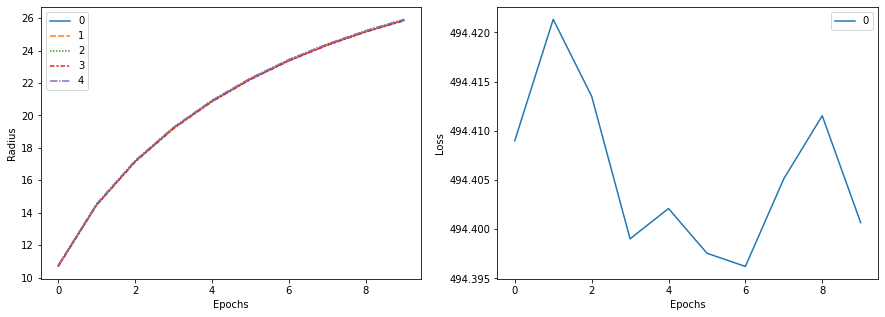

[[58  0  0  0  0  0]
 [ 0 55  0  2  0  1]
 [ 5  0 25  3 23  4]
 [ 0  0  0 58  1  0]
 [ 0  0  0  0 54  3]
 [ 0 14  0 32  1 13]]
74.72
f1_weighted: 0.7105089985448705, f1_macro: 0.7135677944963482, f1_micro: 0.7471590909090909, f_measure: {'Known': 79.2084, 'Open': 32.0988, 'F1-score': 71.3568}
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        58
           1       0.80      0.95      0.87        58
           2       1.00      0.42      0.59        60
           3       0.61      0.98      0.75        59
           4       0.68      0.95      0.79        57
           5       0.62      0.22      0.32        60

    accuracy                           0.75       352
   macro avg       0.77      0.75      0.71       352
weighted avg       0.77      0.75      0.71       352



In [5]:
comment="increasing the data with best setting of ablation 500"
test_data, oset = oset_train(ablation=600,designated_ukc_cls=5,num_classes=5,embedding_size=2,
                             lr_rate=2, optimizer='nadam',
pretrain_epochs=14,octrain_epochs=50, wait_patient=6, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 480
val_0:, 60
test_0:, 60
train_1:, 480
val_1:, 60
test_1:, 60
train_2:, 480
val_2:, 60
test_2:, 60
train_3:, 480
val_3:, 60
test_3:, 60
train_4:, 480
val_4:, 60
test_4:, 60
class 6 is added as ukc
ukc_6:, 60
vocab_size: 50
Epoch 1/14
75/75 [==============================] - 8s 106ms/step - loss: 1.3688 - accuracy: 0.3242 - precision_4: 0.8308 - recall_4: 0.1617 - val_loss: 1.0349 - val_accuracy: 0.4896 - val_precision_4: 0.9580 - val_recall_4: 0.3958
Epoch 2/14
75/75 [==============================] - 7s 99ms/step - loss: 0.8597 - accuracy: 0.6358 - precision_4: 0.8976 - recall_4: 0.4600 - val_loss: 0.6832 - val_accuracy: 0.7639 - val_precision_4: 0.9402 - val_recall_4: 0.6007
Epoch 3/14
75/75 [==============================] - 7s 100ms/step - loss: 0.7474 - accuracy: 0.7179 - precision_4: 0.9

100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:11<00:00,  6.70it/s]


epoch: 1/50, train_loss: 6.592120170593262, F1_train: 0.8520650818882625 F1_val: 0.8203063703084401


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:10<00:00,  6.86it/s]


epoch: 2/50, train_loss: 6.592284202575684, F1_train: 0.9242237873530278 F1_val: 0.897928461685145


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:10<00:00,  7.05it/s]


epoch: 3/50, train_loss: 6.592180252075195, F1_train: 0.9515658962288799 F1_val: 0.9266843670955224


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:10<00:00,  7.06it/s]


epoch: 4/50, train_loss: 6.591987133026123, F1_train: 0.9578715740490632 F1_val: 0.9451933327952058


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:10<00:00,  7.07it/s]


epoch: 5/50, train_loss: 6.5920281410217285, F1_train: 0.959488373775185 F1_val: 0.9441352511886633


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:11<00:00,  6.74it/s]


epoch: 6/50, train_loss: 6.591967582702637, F1_train: 0.9577141652917271 F1_val: 0.9303622744044886


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:11<00:00,  6.78it/s]


epoch: 7/50, train_loss: 6.591949462890625, F1_train: 0.9575223570999188 F1_val: 0.9340997721885648


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:10<00:00,  6.82it/s]


epoch: 8/50, train_loss: 6.592068195343018, F1_train: 0.9575223570999188 F1_val: 0.9319520069660298


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:10<00:00,  6.88it/s]


epoch: 9/50, train_loss: 6.592153549194336, F1_train: 0.9579520175295794 F1_val: 0.9356701649958228


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:10<00:00,  6.98it/s]


epoch: 10/50, train_loss: 6.5920090675354, F1_train: 0.9579520175295794 F1_val: 0.9429248621508933


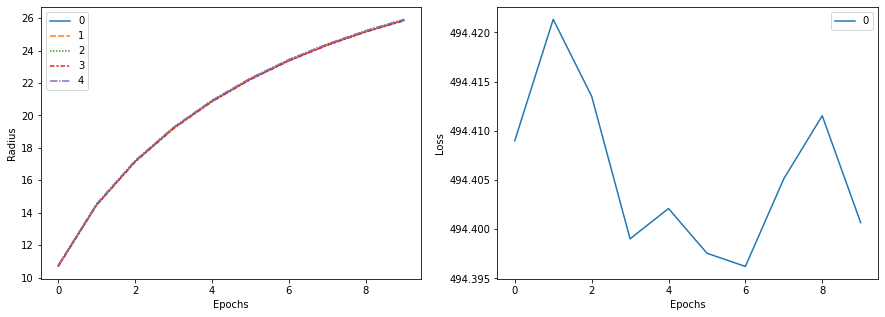

[[58  0  0  0  0  0]
 [ 0 55  0  2  0  1]
 [ 5  0 25  3 23  4]
 [ 0  0  0 58  1  0]
 [ 0  0  0  0 54  3]
 [ 0  2  0 26 15 17]]
75.85
f1_weighted: 0.7319855896164523, f1_macro: 0.7345364171637132, f1_micro: 0.7585227272727274, f_measure: {'Known': 80.1444, 'Open': 40.0, 'F1-score': 73.4536}
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        58
           1       0.96      0.95      0.96        58
           2       1.00      0.42      0.59        60
           3       0.65      0.98      0.78        59
           4       0.58      0.95      0.72        57
           6       0.68      0.28      0.40        60

    accuracy                           0.76       352
   macro avg       0.80      0.76      0.73       352
weighted avg       0.80      0.76      0.73       352



In [6]:
comment="changing class ukc=6"
test_data, oset = oset_train(ablation=600,designated_ukc_cls=6,num_classes=5,embedding_size=2,
                             lr_rate=2, optimizer='nadam',
pretrain_epochs=14,octrain_epochs=50, wait_patient=6, comment=comment)

In [ ]:
def oset_train(ablation=5000,designated_ukc_cls=3,num_classes=2,embedding_size=128,lr_rate=3,optimizer='sgd',
pretrain_epochs=3,octrain_epochs=50,wait_patient=3, debug=False, tracker='tracker.xlsx', comment=''):
    tf.random.set_seed(1234)
    np.random.seed(1234) 
    bglog = BGLog(save_padded_num_sequences=False, debug=debug,  load_from_pkl=True, )
    train_test = bglog.get_tensor_train_val_test(ablation=ablation, designated_ukc_cls=designated_ukc_cls )
    train_data, val_data, test_data = train_test
    line_encoder = LogLineEncoder(bglog, chars_in_line=64)
    logSeqencer =  LogSeqEncoder(line_in_seq=32, dense_neurons=embedding_size)
    ptmodel = LogClassifier(line_encoder=line_encoder, seq_encoder=logSeqencer, num_classes=num_classes)
    ptmodel.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    hist = ptmodel.fit(train_data, validation_data=val_data, epochs=pretrain_epochs)    
    oset = OpenSet(num_classes, ptmodel, embedding_size=embedding_size)
    _, _ = oset.train(train_data,data_val=val_data, epochs=octrain_epochs, lr_rate=lr_rate, wait_patient=wait_patient, optimizer=optimizer)
    _, _, f1_weighted, f_measure = oset.evaluate(test_data, ukc_label=designated_ukc_cls)
    lst = list(tf.reshape(oset.radius, (1, num_classes)).numpy()[0])
    lst = [str(i) for i in lst]
    radius = ','.join(lst)
    loss = oset.losses[len(oset.losses)-1].numpy()
    tracker_data = {'ablation':[ablation],'designated_ukc_cls': [designated_ukc_cls],'num_classes': [num_classes],
                   'embedding_size': [embedding_size], 'lr_rate': [lr_rate], 'optimizer': [optimizer],
                    'pretrain_epochs': [pretrain_epochs],'octrain_epochs': [octrain_epochs], 'wait_patient': [wait_patient], 
                   'f1_weighted': [f1_weighted], 'f1_macro': f_measure.get('F1-score'), 
                   'F1Known': f_measure.get('Known'), 'F1Open': f_measure.get('Open'), 'loss':[loss], 'Radius': radius,
                   'comment': comment}
    update_tracker(tracker, tracker_data)
    return test_data, oset, hist

In [11]:
comment="700 gave pretrained f1 23, so adding more data "
test_data, oset, hist = oset_train(ablation=800,designated_ukc_cls=4,num_classes=4,embedding_size=2,
                             lr_rate=2, optimizer='nadam',
pretrain_epochs=14,octrain_epochs=50, wait_patient=6, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 640
val_0:, 80
test_0:, 80
train_1:, 640
val_1:, 80
test_1:, 80
train_2:, 640
val_2:, 80
test_2:, 80
train_3:, 640
val_3:, 80
test_3:, 80
class 4 is added as ukc
ukc_4:, 80
vocab_size: 50
Epoch 1/14
80/80 [==============================] - 9s 103ms/step - loss: 1.3870 - accuracy: 0.2414 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - val_loss: 1.3863 - val_accuracy: 0.2500 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 2/14
80/80 [==============================] - 8s 104ms/step - loss: 1.3864 - accuracy: 0.2500 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - val_loss: 1.3863 - val_accuracy: 0.2500 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 3/14
80/80 [==============================] - 8s 101ms/step - loss: 1.3864 - accuracy: 0.2398 - precision_8: 0.0000e

KeyboardInterrupt: 